### Sensitive Data

Get the API keys from a git-ignored file

In [ ]:
from sensitive import xfyun_appid, xfyun_seckey, baidu_appid, baidu_seckey

### From Audio to Text

Using IFlyTEK ASR API

In [2]:
import pandas as pd

df = pd.read_csv('dataset/stories_attributes.csv')
df.head()

,filename,Language,Story_type
0,00001.wav,Chinese,True Story
1,00002.wav,Chinese,True Story
2,00003.wav,Chinese,True Story
3,00004.wav,Chinese,True Story
4,00005.wav,Chinese,True Story


In [2]:
from tqdm.notebook import tqdm
import json

from utils.xfyun_asr import RequestApi

file_list = list(zip(df['filename'], df['Language']))
result_list = []
for item in tqdm(file_list):
    api = RequestApi(appid=xfyun_appid,
                     language='cn' if (item[1] == "Chinese") else 'en',
                     secret_key=xfyun_seckey,
                     upload_file_path=f"dataset/stories/{item[0]}")
    result = api.get_result()
    result_json = json.loads(result['content']['orderResult'])
    lattice = result_json['lattice2']
    result_str = ""
    for item in lattice:
        list_words = item['json_1best']['st']['rt'][0]['ws']
        for word in list_words:
            if 'cw' in word:
                word_str = word['cw'][0]['w']
                result_str += word_str
        result_str += "\n"
    result_list.append(result_str)
    
df_result = pd.DataFrame({
    'filename': [item[0] for item in file_list],
    'Language': [item[1] for item in file_list],
    'text': result_list
})

df_result.to_csv('dataset/stories_in_text.csv', index=False, encoding='utf-8')

  0%|          | 0/100 [00:00<?, ?it/s]

uploading part:
upload param: {'appId': 'ac095d8a', 'signa': '3KYtk0f6HASlkfunrVCt2QCsCXs=', 'ts': '1734928477', 'fileSize': 20800614, 'fileName': '00001.wav', 'duration': '200', 'resultType': 'transfer,predict', 'language': 'cn'}
upload_url: https://raasr.xfyun.cn/v2/api/upload?appId=ac095d8a&signa=3KYtk0f6HASlkfunrVCt2QCsCXs%3D&ts=1734928477&fileSize=20800614&fileName=00001.wav&duration=200&resultType=transfer%2Cpredict&language=cn
upload resp: {'code': '000000', 'descInfo': 'success', 'content': {'orderId': 'DKHJQ20241223123440748ROghzBALrIO3NFbq', 'taskEstimateTime': 28000}}

getting part:
get result param: {'appId': 'ac095d8a', 'signa': '3KYtk0f6HASlkfunrVCt2QCsCXs=', 'ts': '1734928477', 'orderId': 'DKHJQ20241223123440748ROghzBALrIO3NFbq', 'resultType': 'transfer,predict', 'language': 'cn'}
status= 3
status= -1
uploading part:
upload param: {'appId': 'ac095d8a', 'signa': 'KRw5qHk0ustquaZZ7AvvvMq715I=', 'ts': '1734928492', 'fileSize': 20728742, 'fileName': '00002.wav', 'duration': 

### Translate to English

In [4]:
import pandas as pd

df = pd.read_csv('dataset/stories_merged_info.csv')
df.head()

,filename,Language,text,label,idx,text_line
0,00001.wav,Chinese,2021年的冬天，\n我回了一趟老家探望外婆，\n那年他身体不好，\n住在离村子不远的小镇医...,0,0,2021年的冬天，我回了一趟老家探望外婆，那年他身体不好，住在离村子不远的小镇医院里，冬天的...
1,00002.wav,Chinese,2022年暑假我终于实现了去云南旅行的梦想。\n云南的美景和独特文化一直是我向往的，\n而这...,0,1,2022年暑假我终于实现了去云南旅行的梦想。云南的美景和独特文化一直是我向往的，而这次旅行让...
2,00003.wav,Chinese,这是我的故事。\n我的旅程从据著名的故宫开始，它是世界上最大保存\n保存最完整的皇宫建筑群。...,0,2,这是我的故事。我的旅程从据著名的故宫开始，它是世界上最大保存保存最完整的皇宫建筑群。当我踏入...
3,00004.wav,Chinese,在2020年呢我报名参加了学校组织的美国研学活动，\n我跟我的另外两个同学以及许多老师同学们...,0,3,在2020年呢我报名参加了学校组织的美国研学活动，我跟我的另外两个同学以及许多老师同学们一起...
4,00005.wav,Chinese,今天我想和大家分享我去年的陕西之旅，\n当我踏上这片古老的土地，心中充满了期待与敬畏。\n我...,0,4,今天我想和大家分享我去年的陕西之旅，当我踏上这片古老的土地，心中充满了期待与敬畏。我在陕西之...


In [19]:
from tqdm.notebook import tqdm
import json
import time

from utils.baidu_translate import baidu_translate

file_list = list(zip(df['filename'], df['Language'], df['text_line']))
result_list = []
for _, lang, text in tqdm(file_list):
    if lang == 'English':
        result_list.append(text)
    else:
        translated = json.loads(baidu_translate(baidu_appid, baidu_seckey, text))
        result_list.append(translated['trans_result'][0]['dst'])
        time.sleep(1)

df_result = pd.DataFrame({
    'filename': [item[0] for item in file_list],
    'Language': [item[1] for item in file_list],
    'text_english': result_list
})

df_result.to_csv('dataset/stories_translated.csv', index=False, encoding='utf-8')

  0%|          | 0/100 [00:00<?, ?it/s]

### Audio Viewer

  0%|          | 0/10 [00:00<?, ?it/s]

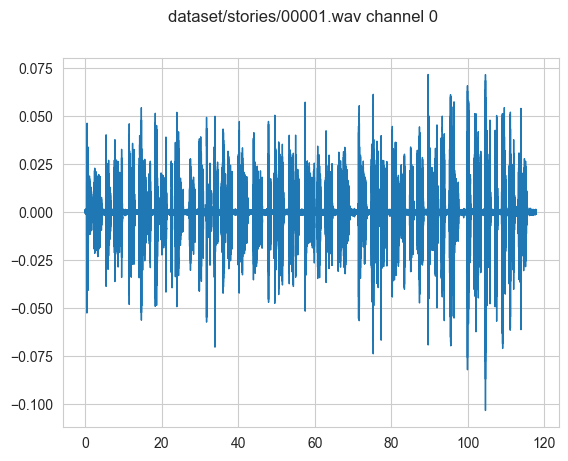

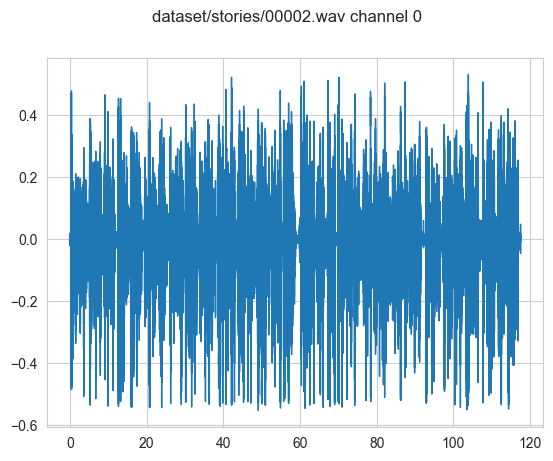

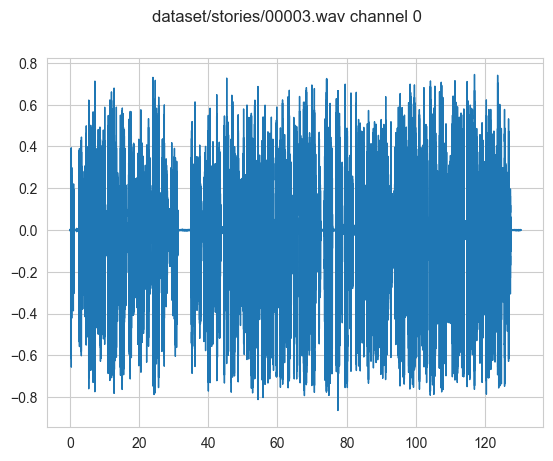

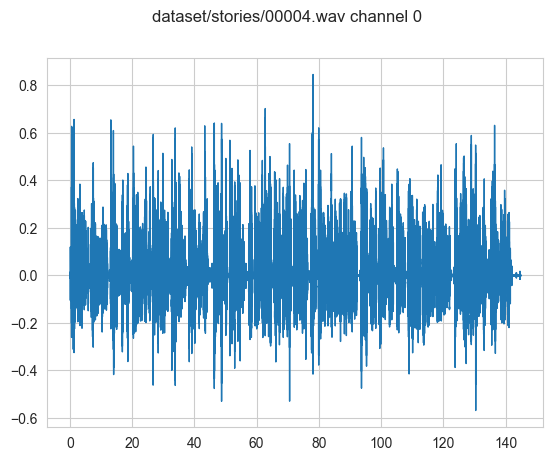

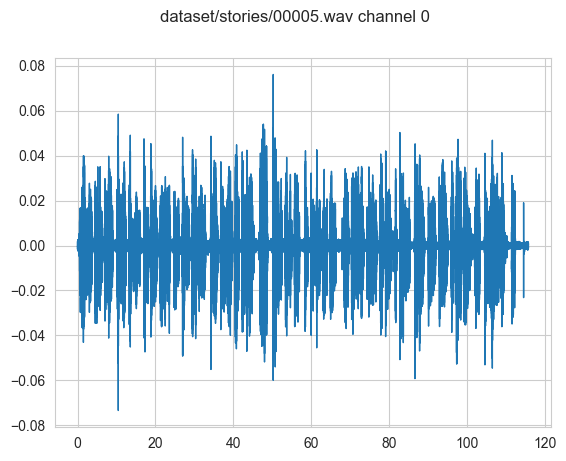

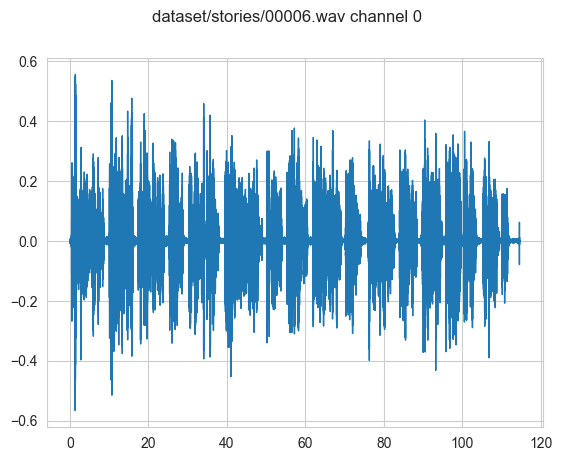

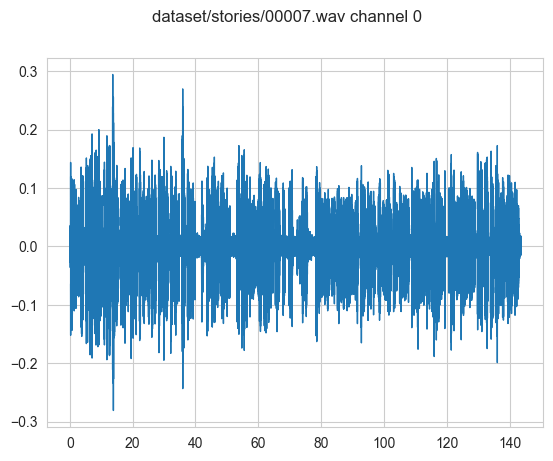

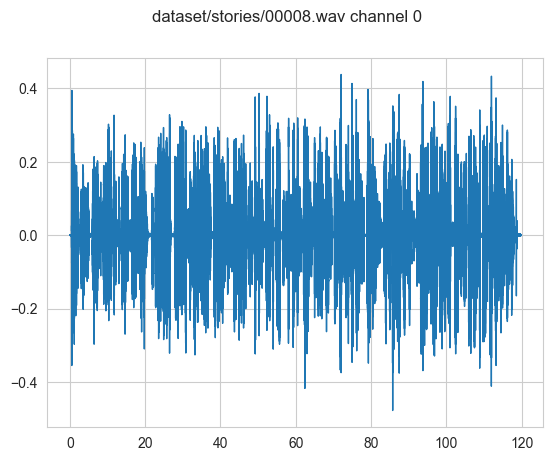

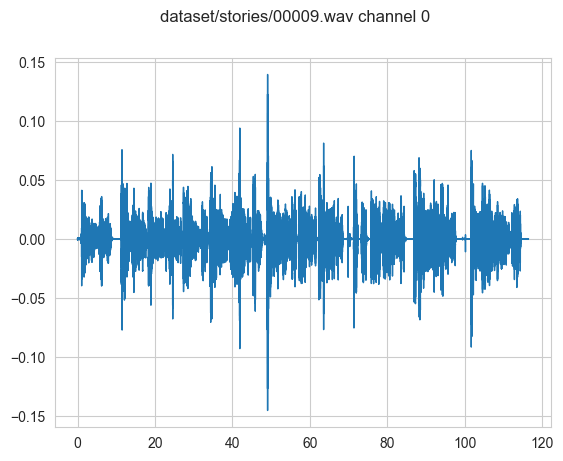

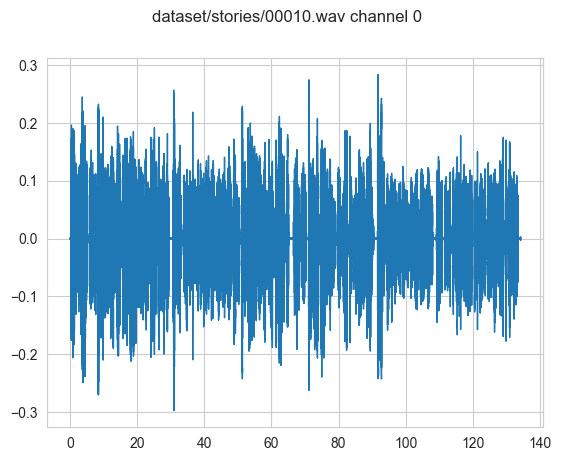

In [6]:
from tqdm.notebook import tqdm
import torchaudio
import torch
import matplotlib.pyplot as plt

def plot_waveform(wav_file, waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(1, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(wav_file + " channel 0")

for i in tqdm(range(10)):
    wav_file = f'dataset/stories/{df.iloc[i]["filename"]}'
    waveform, sample_rate = torchaudio.load(wav_file)
    plot_waveform(wav_file, waveform, sample_rate)